# Installations

In [1]:
!pip install torch
!pip install pytorch_forecasting
!pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 30.5 MB/s eta 0:00:00

# Main part

## Loading df

In [2]:
import os
import numpy as np
import pandas as pd
import librosa as lb
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Global Sample Rate
# SR = 22000
SR = 8000

SEED = 42
np.random.seed(SEED)

DRIVE_PATH = 'drive/MyDrive/psychiatric.disorders.ML'

In [5]:
# participants_info
# participants = pd.read_excel("../Datasets/psychiatric_disorders_data/PsychiatricDiscourse_participant_data.xlsx")

participants = pd.read_excel(os.path.join(DRIVE_PATH, 'PsychiatricDiscourse_participant.data.xlsx'))

In [6]:
participants

ID    group                        diagnosis     sex   age  \
0    PD-001  patient             schizotypal.disorder  female  19.0   
1    PD-002  patient       bipolar.affective.disorder  female  26.0   
2    PD-003  patient             schizotypal.disorder  female  17.0   
3    PD-004  patient  borderline.personality.disorder  female  16.0   
4    PD-005  patient             schizotypal.disorder  female  19.0   
..      ...      ...                              ...     ...   ...   
272  PN-319  control                              NaN  female  27.0   
273  PN-320  control                              NaN  female  27.0   
274  PN-321  control                              NaN    male  26.0   
275  PN-322  control                              NaN  female  41.0   
276  PN-324  control                              NaN  female  26.0   

    education.level  education.years  depression.symptoms  \
0         secondary               11                    1   
1            higher               17                    1   
2         secondary               10                    0   
3         secondary                9                    1   
4         secondary               11                    0   
..              ...              ...                  ...   
272          higher               19                    1   
273          higher               18                    3   
274          higher               17                    1   
275      vocational               13                    0   
276          higher               15                    0   

     thought.disorder.symptoms  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  
..                         ...  
272                          0  
273                          0  
274                          0  
275                          0  
276                          0  

[277 rows x 9 columns]

In [7]:
# depression_only
depression_only = participants.loc[
    (participants['thought.disorder.symptoms'] == 0.) &
    (participants['depression.symptoms'] != 0.)
]

In [8]:
control_group = participants.loc[
    (participants['depression.symptoms'] == 0.) &
    (participants['thought.disorder.symptoms'] == 0.)
]

In [9]:
df = pd.concat([depression_only, control_group])

In [10]:
def get_patient_audio(row, data_folder=os.path.join(DRIVE_PATH, 'wav files'), return_uncomplete=False):
    key = row.ID
    audio_files = []
    for filename in os.listdir(data_folder):
        if filename.find(key) != -1:
            audio_files.append(filename)
    return audio_files

df['audio'] = df.apply(get_patient_audio, axis=1)

# exclude patients with num of recordings other than 3
df = df[df.audio.apply(len) == 3]

In [11]:
os.path.join(DRIVE_PATH, 'wav files')

'drive/MyDrive/psychiatric.disorders.ML/wav files'

In [12]:
task_mapping = {
    'narrative': ['sportsman', 'adventure', 'winterday'], 
    'story': ['present', 'trip', 'party'], 
    'instruction': ['chair', 'table', 'bench']
}

def get_domain_audio(row, domain):
    files = []
    for topic in task_mapping[domain]:
        for file_name in row.audio:
            if file_name.find(topic) != -1:
                files.append(file_name)
                
    if len(files) > 1:
        print(files)
    # assert len(files) < 2
    return files[0] if len(files) else None
    
    
    
for domain in task_mapping:
    df[f'audio.{domain}'] = df.apply(get_domain_audio, axis=1, domain=domain)

<ipython-input-12-a1ddfaf6948f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'audio.{domain}'] = df.apply(get_domain_audio, axis=1, domain=domain)
<ipython-input-12-a1ddfaf6948f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'audio.{domain}'] = df.apply(get_domain_audio, axis=1, domain=domain)


In [13]:
df.head()

ID    group                        diagnosis     sex   age  \
0   PD-001  patient             schizotypal.disorder  female  19.0   
1   PD-002  patient       bipolar.affective.disorder  female  26.0   
3   PD-004  patient  borderline.personality.disorder  female  16.0   
7   PD-008  patient       bipolar.affective.disorder  female  19.0   
12  PD-013  patient    recurrent.depressive.disorder  female  20.0   

      education.level  education.years  depression.symptoms  \
0           secondary               11                    1   
1              higher               17                    1   
3           secondary                9                    1   
7   higher.unfinished               12                    1   
12  higher.unfinished               12                    1   

    thought.disorder.symptoms  \
0                           0   
1                           0   
3                           0   
7                           0   
12                          0   

                                                audio  \
0   [PD-001-pers-1-present.wav, PD-001-instr-1-cha...   
1   [PD-002-pers-1-present.wav, PD-002-instr-1-cha...   
3   [PD-004-pic-1-adventure.wav, PD-004-pers-1-pre...   
7   [PD-008-instr-1-chair.wav, PD-008-pic-1-advent...   
12  [PD-013-pic-1-sportsman.wav, PD-013-pers-1-pre...   

               audio.narrative                audio.story  \
0   PD-001-pic-1-sportsman.wav  PD-001-pers-1-present.wav   
1   PD-002-pic-1-adventure.wav  PD-002-pers-1-present.wav   
3   PD-004-pic-1-adventure.wav  PD-004-pers-1-present.wav   
7   PD-008-pic-1-adventure.wav  PD-008-pers-1-present.wav   
12  PD-013-pic-1-sportsman.wav  PD-013-pers-1-present.wav   

           audio.instruction  
0   PD-001-instr-1-chair.wav  
1   PD-002-instr-1-chair.wav  
3   PD-004-instr-1-chair.wav  
7   PD-008-instr-1-chair.wav  
12  PD-013-instr-1-chair.wav

In [14]:
df['depression.symptoms'].value_counts()

0    142
1     62
2     22
3     10
Name: depression.symptoms, dtype: int64

In [15]:
df[['audio.narrative', 'audio.story', 'audio.instruction']].dropna()

audio.narrative                audio.story  \
0    PD-001-pic-1-sportsman.wav  PD-001-pers-1-present.wav   
1    PD-002-pic-1-adventure.wav  PD-002-pers-1-present.wav   
3    PD-004-pic-1-adventure.wav  PD-004-pers-1-present.wav   
7    PD-008-pic-1-adventure.wav  PD-008-pers-1-present.wav   
12   PD-013-pic-1-sportsman.wav  PD-013-pers-1-present.wav   
..                          ...                        ...   
267  PN-314-pic-1-adventure.wav    PN-314-pers-1-party.wav   
268  PN-315-pic-1-adventure.wav    PN-315-pers-1-party.wav   
271  PN-318-pic-1-winterday.wav     PN-318-pers-1-trip.wav   
275  PN-322-pic-1-winterday.wav     PN-322-pers-1-trip.wav   
276  PN-324-pic-1-winterday.wav  PN-324-pers-1-present.wav   

            audio.instruction  
0    PD-001-instr-1-chair.wav  
1    PD-002-instr-1-chair.wav  
3    PD-004-instr-1-chair.wav  
7    PD-008-instr-1-chair.wav  
12   PD-013-instr-1-chair.wav  
..                        ...  
267  PN-314-instr-1-bench.wav  
268  PN-315-instr-1-bench.wav  
271  PN-318-instr-1-chair.wav  
275  PN-322-instr-1-bench.wav  
276  PN-324-instr-1-chair.wav  

[236 rows x 3 columns]

In [16]:
#80% training data and 20% test data. Split so that test data will include all types of depression severity

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, train_size = 0.8, random_state = 42)

for (train_index, test_index) in sss.split(df, df['depression.symptoms']):
  train_df = df.iloc[train_index]
  test_df = df.iloc[test_index]

In [17]:
train_df.head()

ID    group                      diagnosis     sex   age  \
189  PN-075  control                            NaN    male  23.0   
32   PD-034  patient     bipolar.affective.disorder  female  20.0   
259  PN-306  control                            NaN    male  53.0   
179  PN-054  control                            NaN  female  24.0   
84   PD-089  patient  recurrent.depressive.disorder  female  17.0   

           education.level  education.years  depression.symptoms  \
189             vocational               14                    2   
32       higher.unfinished               13                    0   
259                 higher               20                    0   
179                 higher               17                    2   
84   vocational.unfinished               10                    0   

     thought.disorder.symptoms  \
189                          0   
32                           0   
259                          0   
179                          0   
84                           0   

                                                 audio  \
189  [PN-075-instr-1-table.wav, PN-075-pers-1-trip....   
32   [PD-034-instr-1-chair.wav, PD-034-pic-1-advent...   
259  [PN-306-instr-1-bench.wav, PN-306-pic-1-winter...   
179  [PN-054-pers-1-party.wav, PN-054-instr-1-chair...   
84   [PD-089-pers-1-present.wav, PD-089-instr-1-cha...   

                audio.narrative                audio.story  \
189  PN-075-pic-1-adventure.wav     PN-075-pers-1-trip.wav   
32   PD-034-pic-1-adventure.wav  PD-034-pers-1-present.wav   
259  PN-306-pic-1-winterday.wav    PN-306-pers-1-party.wav   
179  PN-054-pic-1-adventure.wav    PN-054-pers-1-party.wav   
84   PD-089-pic-1-adventure.wav  PD-089-pers-1-present.wav   

            audio.instruction  
189  PN-075-instr-1-table.wav  
32   PD-034-instr-1-chair.wav  
259  PN-306-instr-1-bench.wav  
179  PN-054-instr-1-chair.wav  
84   PD-089-instr-1-chair.wav

In [18]:
test_df.shape

(48, 13)

## Data and train

### Packages and functions

In [19]:
# from tqdm import tqdm
from tqdm.auto import tqdm
import pytorch_forecasting as ptf
import torch
from pytorch_forecasting import DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_forecasting.metrics import RMSE, MultivariateNormalDistributionLoss, DistributionLoss
from dtaidistance import dtw
from itertools import product
import sklearn.metrics as skm 


import warnings
warnings.filterwarnings('ignore')


pl.seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


cpu


In [20]:
def concat_df(new_df_narr, new_df_story, new_df_instr):
  un_narr = new_df_narr['group'].unique()
  un_story = new_df_story['group'].unique()
  un_instr = new_df_instr['group'].unique()

  new_df = pd.DataFrame(columns = ['narrative', 'story', 'instruction', 'time_idx', 'group'])
  time_idx = new_df_narr.loc[new_df_narr['group'] == un_narr[0]]['time_idx']

  for group in np.unique(np.concatenate((un_narr, un_story, un_instr), 0)):
    flag_narr = group in un_narr
    flag_story = group in un_story
    flag_instr = group in un_instr
    tmp_df = pd.DataFrame()

    if flag_narr:
      tmp_df['narrative'] = new_df_narr.loc[new_df_narr['group'] == group]['observations'].values
    else:
      tmp_df['narrative'] = new_df_narr.loc[new_df_narr['group'] == '00' + group[2:]]['observations'].values

    if flag_story:
      tmp_df['story'] = new_df_story.loc[new_df_story['group'] == group]['observations'].values
    else:
      tmp_df['story'] = new_df_story.loc[new_df_story['group'] == '00' + group[2:]]['observations'].values

    if flag_instr:
      tmp_df['instruction'] = new_df_instr.loc[new_df_instr['group'] == group]['observations'].values
    else:
      tmp_df['instruction'] = new_df_instr.loc[new_df_instr['group'] == '00' + group[2:]]['observations'].values

    tmp_df['time_idx'] = time_idx
    tmp_df['group'] = group
    new_df = pd.concat([new_df, tmp_df], axis=0, ignore_index=True)
  
  new_df['time_idx'] = new_df['time_idx'].astype(int)
  return new_df

In [21]:
def cut_recordings(data, audio_dur, cutoff_len, min_len = 0):
  res = []
  cnt = 1
  res.append(data[:int(cutoff_len * SR)])
  audio_dur -= cutoff_len

  while(audio_dur > min_len and cnt<10):
    res.append(data[int(cutoff_len * SR)*cnt:int(cutoff_len * SR)*(cnt+1)])
    audio_dur -= cutoff_len
    cnt += 1

  return res


def pad_ts(data, max_dur):
  for i in range(len(data)):
      if (len(data[i]) < max_dur):
        data[i] = np.pad(data[i], (max_dur - len(data[i]), 0), 'constant', constant_values=(0,))

  return data


def load_and_preprocess(files, data_folder, cutoff_len = 0, min_len=0):
  audio_ts = []

  for filename in files:
      signal, sr = lb.load(os.path.join(data_folder, filename), sr=SR)
      signal, _ = lb.effects.trim(signal, top_db=40)
      audio_ts.append(signal)


  for i in range(len(audio_ts)):
    audio_dur = len(audio_ts[i]) / SR

    audio_ts[i] = cut_recordings(data = audio_ts[i], audio_dur = audio_dur, 
                                 cutoff_len = cutoff_len, min_len = min_len)
    audio_ts[i] = pad_ts(audio_ts[i], cutoff_len*SR)

  upd_df = pd.DataFrame(columns=[f'observations', 'time_idx', 'group'])
  audio_len = len(audio_ts[0][0])


  for i in range(len(audio_ts)):
    for j in range(len(audio_ts[i])):
      if j < 10:
        tmp_df = pd.DataFrame({'observations':audio_ts[i][j], 'time_idx' : np.arange(audio_len), 'group':[f'0{j}_' + files.iloc[i]] * audio_len})
      else: 
        tmp_df = pd.DataFrame({'observations':audio_ts[i][j], 'time_idx' : np.arange(audio_len), 'group':[f'{j}_' + files.iloc[i]] * audio_len})

      upd_df = pd.concat([upd_df, tmp_df], axis=0, ignore_index=True)

  upd_df['time_idx'] = upd_df['time_idx'].astype(int)

  return upd_df


def create_timeSeriesDataSet(df, encoder_len = 60, prediction_len = 60):
  # Replace "." with "_"
  df.columns = [col.replace(".", "_") for col in df.columns]

  # Define the TimeSeriesDataSet object
  training_cutoff = df["time_idx"].max() - prediction_len

  training = TimeSeriesDataSet(
      data=df.loc[lambda x: x.time_idx <= training_cutoff],
      time_idx="time_idx",
      target = ['narrative', 'story', 'instruction'],
      group_ids= ["group"],
      max_encoder_length=encoder_len,
      max_prediction_length=prediction_len,
      time_varying_unknown_reals=['narrative', 'story', 'instruction'],
      # time_varying_known_reals=["time_idx"], #for tft
  )

  validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training_cutoff+1)

  return (training, validation)


def create_timeSeriesDataSet_test(df, encoder_len = 60, prediction_len = 60):
  # Replace "." with "_"
  df.columns = [col.replace(".", "_") for col in df.columns]

  # Define the TimeSeriesDataSet object
  training_cutoff = df["time_idx"].max() - prediction_len

  test = TimeSeriesDataSet(
      data=df,
      time_idx="time_idx",
      target = ['narrative', 'story', 'instruction'],
      group_ids= ["group"],
      max_encoder_length=encoder_len,
      max_prediction_length=prediction_len,
      time_varying_unknown_reals=['narrative', 'story', 'instruction'],
      # time_varying_known_reals=["time_idx"], # for tft
      min_prediction_idx=training_cutoff+1,
  )

  return test

def classify_obs(pid, pred, df, data_folder, size_of_pred, audio_ts, stimuli_type):
  min_dist = float('inf')
  most_similar = None

  for filename in df[f'audio.{stimuli_type}']:
    distance_dtw = dtw.distance_fast(pred, audio_ts[filename][-size_of_pred:].astype(np.double))

    if distance_dtw < min_dist:
      min_dist = distance_dtw
      most_similar = filename
    
  return (pid, df[df[f'audio.{stimuli_type}'] == most_similar]['depression.symptoms'].iloc[0], min_dist)

### Training the model

In [ ]:
BASE_LEN = 83
BATCH_SIZE = 2
LR = 1e-3
HIDDEN_SIZE = 10
RNN_LAYERS = 2
EPOCHS = 2
LIMIT_TRAIN_BATCHES = 2000

In [ ]:
# Read first 4 observations
files = train_df['audio.narrative'][:4]
data_folder=os.path.join(DRIVE_PATH, 'wav files')
new_df = load_and_preprocess(files, data_folder, cutoff_len = BASE_LEN, min_len = 24)

files = train_df['audio.story'][:4]
new_df['observations_story'] = load_and_preprocess(files, data_folder, cutoff_len = BASE_LEN, min_len = 24)['observations']

files = train_df['audio.instruction'][:4]
new_df['observations_instruction'] = load_and_preprocess(files, data_folder, cutoff_len = BASE_LEN, min_len = 24)['observations']

train_val = create_timeSeriesDataSet(new_df)

train_dataloader = train_val[0].to_dataloader(
    train=True, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
)
# DeepAR model
net = DeepAR.from_dataset(
    train_val[0],
    learning_rate=1e-3,
    hidden_size=10,
    rnn_layers=2,
    optimizer="AdamW",
)
net.to(device)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")

# Fit for the rest observations
for i in tqdm(range(0,len(train_df['audio.narrative']), 4)):

  files = train_df['audio.narrative'][i:i+4]
  data_folder=os.path.join(DRIVE_PATH, 'wav files')
  new_df = load_and_preprocess(files, data_folder)
  files = train_df['audio.story'][i:i+4]
  new_df['observations_story'] = load_and_preprocess(files, data_folder, min_len = 24)['observations']
  files = train_df['audio.instruction'][i:i+4]
  new_df['observations_instruction'] = load_and_preprocess(files, data_folder, min_len = 24)['observations']

  train_val = create_timeSeriesDataSet(new_df)

  train_dataloader = train_val[0].to_dataloader(
      train=True, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
  )

  val_dataloader = train_val[1].to_dataloader(
      train=False, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
  )

  trainer = pl.Trainer(
    max_epochs=2, #10 FOR NOW
    accelerator="gpu",
    enable_model_summary=False,
    gradient_clip_val=0.1,
    # limit_train_batches=2000,
    limit_train_batches=200,
    callbacks=[early_stop_callback],
    enable_checkpointing=True,
    check_val_every_n_epoch=1,
    # reload_dataloaders_every_n_epochs = 10
  ) 

  trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
  )

  

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


  0%|          | 0/46 [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


### Fine-tuning

In [22]:
data_folder=os.path.join(DRIVE_PATH, 'wav files')

BATCH_SIZE = 8
LIMIT_TRAIN_BATCHES = 3000
EPOCHS = 2
BASE_LEN_f = 5

PREDICTION_LENGTH = 200
CONTEXT_LENGTH = 200 
LR = 5e-3

In [23]:
class loss_aa(DistributionLoss):
  def map_x_to_distribution(self, x):
    return torch.distributions.normal.Normal(x.mean(axis=2), torch.log(1 + torch.exp(x)).mean(axis=2))

def move_to_device(x):
  if type(x) == list:
    x = [i.to(device) for i in x]
  else:
    x = x.to(device)
  return x

def train_model(model, epochs):
  # Fit for the rest observations
  criterion = loss_aa()
  optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

  for i in tqdm(range(0, len(train_df['audio.narrative']), 4), desc='Files loaded'):
    if (i+4 > len(train_df['audio.narrative'])):
      files_narr = train_df['audio.narrative'][i:]
      files_story = train_df['audio.story'][i:]
      files_instr = train_df['audio.instruction'][i:]
    else:
      files_narr = train_df['audio.narrative'][i:i+4]
      files_story = train_df['audio.story'][i:i+4]
      files_instr = train_df['audio.instruction'][i:i+4]

    data_folder=os.path.join(DRIVE_PATH, 'wav files')

    new_df_narr = load_and_preprocess(files_narr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
    new_df_story = load_and_preprocess(files_story, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
    new_df_instr = load_and_preprocess(files_instr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)

    new_df_narr['group'] = new_df_narr['group'].apply(lambda x : x[:9])
    new_df_story['group'] = new_df_story['group'].apply(lambda x : x[:9])
    new_df_instr['group'] = new_df_instr['group'].apply(lambda x : x[:9])

    new_df = concat_df(new_df_narr, new_df_story, new_df_instr)

    train_val = create_timeSeriesDataSet(new_df, prediction_len=PREDICTION_LENGTH, encoder_len=CONTEXT_LENGTH)

    train_dataloader = train_val[0].to_dataloader(
        train=True, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
    )

    val_dataloader = train_val[1].to_dataloader(
        train=False, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
    )
    for epoch in range(epochs):

      model.train()
      train_it = iter(train_dataloader)
      train_loss = 0
      for n_batches in range(LIMIT_TRAIN_BATCHES):
        batch = next(train_it)
        x = {k: move_to_device(v) for k, v in batch[0].items()}
        y = [v.to(device) for v in batch[1][0]]

        out = model.forward(x)
        loss = criterion(out['prediction'][0], y[0])
        loss += criterion(out['prediction'][1], y[1])
        loss += criterion(out['prediction'][2], y[2])
        loss = loss / 3

        train_loss += loss.detach()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


      model.eval()
      iteration = 0
      overall_loss = 0
      for val_batch in val_dataloader:
        x_val = {k: move_to_device(v) for k, v in val_batch[0].items()}
        y_val = [v.to(device) for v in val_batch[1][0]]
        
        out = model.forward(x_val)
        loss = criterion(out['prediction'][0], y_val[0])
        loss += criterion(out['prediction'][1], y_val[1])
        loss += criterion(out['prediction'][2], y_val[2])
        loss = loss / 3

        iteration += 1
        overall_loss += loss.detach()
      
      # print(f"Epoch {epoch} Train loss: ", round(float(train_loss / LIMIT_TRAIN_BATCHES), 4), "\tVal loss: ",  round(float(overall_loss / iteration), 4))
  return model 

In [24]:
grid_v2 = { 'PREDICTION_CONTEXT_LENGTH': [[PREDICTION_LENGTH, CONTEXT_LENGTH]],
        'hidden_size ' : [32, 64, 80],
        'rnn_layers  ' : [2, 4, 6],
}

In [25]:
from itertools import product

deepar_paths = "/content/drive/MyDrive/Grid_search_thesis/DeepAR_models"

for i, params in tqdm(enumerate(product(*grid_v2.values())), total = len(list(product(*grid_v2.values()))), desc='Grid search progress'):
  if os.path.isfile(os.path.join(deepar_paths, f'Deepar_{i}.pt')):
    continue

  files_narr = train_df['audio.narrative'][:2]
  files_story = train_df['audio.story'][:2]
  files_instr = train_df['audio.instruction'][:2]

  new_df_narr = load_and_preprocess(files_narr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
  new_df_story = load_and_preprocess(files_story, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
  new_df_instr = load_and_preprocess(files_instr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)

  new_df_narr['group'] = new_df_narr['group'].apply(lambda x : x[:9])
  new_df_story['group'] = new_df_story['group'].apply(lambda x : x[:9])
  new_df_instr['group'] = new_df_instr['group'].apply(lambda x : x[:9])

  new_df = concat_df(new_df_narr, new_df_story, new_df_instr)

  train_val = create_timeSeriesDataSet(new_df, prediction_len=PREDICTION_LENGTH, encoder_len=CONTEXT_LENGTH)

  train_dataloader = train_val[0].to_dataloader(
      train=True, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
  )
  # DeepAR model
  net_deepar = DeepAR.from_dataset(
      train_val[0],
      learning_rate=LR,
      hidden_size=params[1],
      rnn_layers=params[2],
      optimizer="AdamW",
  )
  net_deepar.to(device)

  # net_deepar = train_model(net_deepar, epochs=2,)

  torch.save({'model_state_dict' : net_deepar.state_dict(),
            'hyperparameters' : net_deepar.hparams}, 
           os.path.join(deepar_paths, f'Deepar_{i}.pt'))

Grid search progress:   0%|          | 0/9 [00:00<?, ?it/s]

### Predictions

In [22]:
def classify_obs(pid, pred, df, data_folder, size_of_pred, audio_ts, stimuli_type):
  min_dist = float('inf')
  most_similar = None

  for filename in df[f'audio.{stimuli_type}']:
    distance_dtw = dtw.distance_fast(pred, audio_ts[filename][-size_of_pred:].astype(np.double))

    if distance_dtw < min_dist:
      min_dist = distance_dtw
      most_similar = filename
    
  return (pid, df[df[f'audio.{stimuli_type}'] == most_similar]['depression.symptoms'].iloc[0], min_dist)

In [24]:
data_folder=os.path.join(DRIVE_PATH, 'wav files')

BATCH_SIZE = 8
LIMIT_TRAIN_BATCHES = 3000
EPOCHS = 2
BASE_LEN_f = 5

PREDICTION_LENGTH = 200
CONTEXT_LENGTH = 200 
LR = 5e-3

In [28]:
deepar_paths = "/content/drive/MyDrive/Grid_search_thesis/DeepAR_models"
deepar_predictions_paths = '/content/drive/MyDrive/Grid_search_thesis/DeepAR_models/predictions'

files_narr = test_df['audio.narrative']
files_story = test_df['audio.story']
files_instr = test_df['audio.instruction']

new_df_narr = load_and_preprocess(files_narr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
new_df_story = load_and_preprocess(files_story, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
new_df_instr = load_and_preprocess(files_instr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)

new_df_narr['group'] = new_df_narr['group'].apply(lambda x : x[:9])
new_df_story['group'] = new_df_story['group'].apply(lambda x : x[:9])
new_df_instr['group'] = new_df_instr['group'].apply(lambda x : x[:9])

new_df = concat_df(new_df_narr, new_df_story, new_df_instr)

test = create_timeSeriesDataSet_test(new_df, prediction_len=PREDICTION_LENGTH, encoder_len=CONTEXT_LENGTH)

test_dataloader = test.to_dataloader(
    train=False, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
)

In [49]:
for i in tqdm(range(9)):
  checkpoint = torch.load(os.path.join(deepar_paths, f'Deepar_{i}.pt'), map_location=torch.device(device))

  # DeepAR model
  net_deepar = DeepAR.from_dataset(
      test,
      learning_rate=LR,
      hidden_size=checkpoint['hyperparameters']['hidden_size'],
      rnn_layers=checkpoint['hyperparameters']['rnn_layers'],
      optimizer="AdamW",
  )
  net_deepar.to(device)

  raw_predictions = net_deepar.predict(
    test_dataloader, mode="raw",
  )

  types = ['narrative', 'story', 'instruction']
  pred_df = pd.DataFrame()


  for st, stimuli_type in enumerate(types):

    predicted_classes = []
    size_of_pred = raw_predictions['prediction'][st].shape[1]
    groups = new_df['group'].unique()

    audio_ts = {}

    for filename in train_df[f'audio.{stimuli_type}']:
        signal, sr = lb.load(os.path.join(data_folder, filename), sr=SR)
        signal, _ = lb.effects.trim(signal, top_db=35)
        audio_ts[filename] = signal

    for m in range(raw_predictions['prediction'][st].shape[0]):
      tmp = classify_obs(pid = groups[m], 
                        pred = raw_predictions['prediction'][st][m].mean(axis=1).detach().cpu().numpy().astype(np.double),
                        df = train_df, 
                        data_folder = data_folder,
                        size_of_pred = size_of_pred,
                        audio_ts = audio_ts,
                        stimuli_type = stimuli_type)
      predicted_classes.append(tmp)


    pred_df_stimuli = pd.DataFrame(predicted_classes, columns=['id', f'pred_{stimuli_type}', f'min_dist_{stimuli_type}'])
    pred_df['id'] = pred_df_stimuli['id']
    pred_df[f'pred_{stimuli_type}'] = pred_df_stimuli[f'pred_{stimuli_type}']
    pred_df[f'min_dist_{stimuli_type}'] = pred_df_stimuli[f'min_dist_{stimuli_type}']
    
  pred_df['actual_severity'] = [test_df[test_df[f'ID'] == j[3:]]['depression.symptoms'].iloc[0] for j in pred_df['id']]
  pred_df.to_csv(os.path.join(deepar_predictions_paths,f'Deepar_{i}_pred_multiple.csv'))

  0%|          | 0/8 [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available:

### Choose best model 

In [26]:
deepar_paths = "/content/drive/MyDrive/Grid_search_thesis/DeepAR_models"

checkpoint = torch.load(os.path.join(deepar_paths, f'Deepar_{1}.pt'), map_location=torch.device(device))

# checkpoint['hyperparameters']

In [36]:
import sklearn.metrics as skm 

deepar_paths = "/content/drive/MyDrive/Grid_search_thesis/DeepAR_models"
deepar_predictions_paths = '/content/drive/MyDrive/Grid_search_thesis/DeepAR_models/predictions'

# stimuli_type = 'narrative'
# stimuli_type = 'story'
# stimuli_type = 'instruction'

best_score = 0
model_n = 0

for j in range(9):
  predictions = pd.read_csv(os.path.join(deepar_predictions_paths, f'Deepar_{j}_pred_multiple.csv'), index_col=0)
  predictions['id'] = predictions['id'].apply(lambda x: x[3:])

  # predictions = pd.read_csv(os.path.join(deepar_predictions_paths, f'Deepar_{1}_pred_multiple.csv'), index_col=0)
  # predictions['id'] = predictions['id'].apply(lambda x: x[3:])

  maj_voting_pred = predictions.groupby(['id']).agg(lambda x:x.value_counts().index[0])

  report_deepar = skm.classification_report(maj_voting_pred['actual_severity'], maj_voting_pred[['pred_narrative', 'pred_story', 'pred_instruction']].mode(axis=1)[0], output_dict=True)

  if report_deepar['weighted avg']['f1-score'] > best_score:
    model_n = j
    best_score = report_deepar['weighted avg']['f1-score']

print(model_n, best_score)

1 0.5636473429951692


### CV

In [27]:
BATCH_SIZE = 8
LIMIT_TRAIN_BATCHES = 3000
EPOCHS = 2
BASE_LEN_f = 5

PREDICTION_LENGTH = 400
CONTEXT_LENGTH = 800 
LR = 3e-3

data_folder=os.path.join(DRIVE_PATH, 'wav files')

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, train_size = 0.8, random_state = 42)
cv_splits = {}


for i, (train_index, test_index) in enumerate(sss.split(df, df['depression.symptoms'])):
  cv_splits[i] = (train_index, test_index)

In [ ]:
deepar_predictions_paths = '/content/drive/MyDrive/Grid_search_thesis/DeepAR_models/predictions'
deepar_cv = '/content/drive/MyDrive/Grid_search_thesis/DeepAR_models/cv'
deepar_paths = "/content/drive/MyDrive/Grid_search_thesis/DeepAR_models"

checkpoint = torch.load(os.path.join(deepar_paths, f'Deepar_{1}.pt'), map_location=torch.device(device))

for i, idx in enumerate(cv_splits.values()):
    # Obtain new train and test dataframes
    train_df = df.iloc[idx[0]]
    test_df = df.iloc[idx[1]]


    # Initialize the model
    data_folder=os.path.join(DRIVE_PATH, 'wav files')

    files_narr = train_df['audio.narrative'][:2]
    files_story = train_df['audio.story'][:2]
    files_instr = train_df['audio.instruction'][:2]

    new_df_narr = load_and_preprocess(files_narr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
    new_df_story = load_and_preprocess(files_story, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
    new_df_instr = load_and_preprocess(files_instr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)

    new_df_narr['group'] = new_df_narr['group'].apply(lambda x : x[:9])
    new_df_story['group'] = new_df_story['group'].apply(lambda x : x[:9])
    new_df_instr['group'] = new_df_instr['group'].apply(lambda x : x[:9])

    new_df = concat_df(new_df_narr, new_df_story, new_df_instr)

    train_val = create_timeSeriesDataSet(new_df, prediction_len=PREDICTION_LENGTH, encoder_len=CONTEXT_LENGTH)

    train_dataloader = train_val[0].to_dataloader(
        train=True, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
    )
    # DeepAR model
    net_deepar = DeepAR.from_dataset(
        train_val[0],
        learning_rate=LR,
        hidden_size=10,
        rnn_layers=2,
        optimizer="AdamW",
    )
    net_deepar.to(device)
    #Training
    # net_deepar = train_model(net_deepar, epochs=3)

    #Obtain predictions
    files_narr = test_df['audio.narrative']
    files_story = test_df['audio.story']
    files_instr = test_df['audio.instruction']

    new_df_narr = load_and_preprocess(files_narr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
    new_df_story = load_and_preprocess(files_story, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)
    new_df_instr = load_and_preprocess(files_instr, data_folder, cutoff_len = BASE_LEN_f, min_len = BASE_LEN_f)

    new_df_narr['group'] = new_df_narr['group'].apply(lambda x : x[:9])
    new_df_story['group'] = new_df_story['group'].apply(lambda x : x[:9])
    new_df_instr['group'] = new_df_instr['group'].apply(lambda x : x[:9])

    new_df = concat_df(new_df_narr, new_df_story, new_df_instr)

    test = create_timeSeriesDataSet_test(new_df, prediction_len=PREDICTION_LENGTH, encoder_len=CONTEXT_LENGTH)

    test_dataloader = test.to_dataloader(
        train=False, batch_size=BATCH_SIZE, num_workers=0, batch_sampler="synchronized"
    )

    raw_predictions = net_deepar.predict(
      test_dataloader, mode="raw",
    )

    types = ['narrative', 'story', 'instruction']
    pred_df = pd.DataFrame()


    for st, stimuli_type in enumerate(types):

      predicted_classes = []
      size_of_pred = raw_predictions['prediction'][st].shape[1]
      groups = new_df['group'].unique()

      audio_ts = {}

      for filename in train_df[f'audio.{stimuli_type}']:
          signal, sr = lb.load(os.path.join(data_folder, filename), sr=SR)
          signal, _ = lb.effects.trim(signal, top_db=35)
          audio_ts[filename] = signal

      for m in range(raw_predictions['prediction'][st].shape[0]):
        tmp = classify_obs(pid = groups[m], 
                          pred = raw_predictions['prediction'][st][m].mean(axis=1).detach().cpu().numpy().astype(np.double),
                          df = train_df, 
                          data_folder = data_folder,
                          size_of_pred = size_of_pred,
                          audio_ts = audio_ts,
                          stimuli_type = stimuli_type)
        predicted_classes.append(tmp)


      pred_df_stimuli = pd.DataFrame(predicted_classes, columns=['id', f'pred_{stimuli_type}', f'min_dist_{stimuli_type}'])
      pred_df['id'] = pred_df_stimuli['id']
      pred_df[f'pred_{stimuli_type}'] = pred_df_stimuli[f'pred_{stimuli_type}']
      pred_df[f'min_dist_{stimuli_type}'] = pred_df_stimuli[f'min_dist_{stimuli_type}']
      
    pred_df['actual_severity'] = [test_df[test_df[f'ID'] == j[3:]]['depression.symptoms'].iloc[0] for j in pred_df['id']]

    pred_df['id'] = pred_df['id'].apply(lambda x: x[3:])


    maj_voting_pred = pred_df.groupby(['id']).agg(lambda x:x.value_counts().index[0])


    deepar_pred = maj_voting_pred[['pred_narrative', 'pred_story', 'pred_instruction']].mode(axis=1)[0]

    deepar_final = pd.DataFrame([deepar_pred, maj_voting_pred['actual_severity']]).T

    deepar_final['id'] = deepar_final.index.values
    deepar_final = deepar_final.reset_index(drop=True)
    deepar_final.rename({0 : 'pred_severity'}, axis=1, inplace=True)
    deepar_final.to_csv(os.path.join(deepar_cv, f'deepar_fold_{i}_pred.csv'), index=False)

# **Playground**

## **Cut into multiple recordings**

In [ ]:
from tqdm import tqdm
import pytorch_forecasting as ptf
import torch
from pytorch_forecasting import DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping

pl.seed_everything(42)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


42

In [ ]:
files = df['audio.narrative'][:4]
data_folder=os.path.join(DRIVE_PATH, 'wav files')

audio_ts = []

for _, filename in tqdm(files.items(), total=len(files)):
    signal, sr = lb.load(os.path.join(data_folder, filename), sr=SR)
    audio_ts.append(signal)

  

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]


Based on the statistics described median recording length is around 80 seconds. Let's take this as the length to which we want to bring all of other. I'm not choosing the lowest length due to the possibility of newly obtained recordings to be uninformative and become useless after splitting into that many parts. Whereas with the median recording length we can both pad the shorter recodings without losing any information and cut the longer ones. The reason for not choosing the mean recording length is the skew of their distribution. From the plots of recordings durations we may observe the presence of few anomalously long recordings, which could have had a great effect on our mean value.

In [ ]:
def cut_recordings(data, audio_dur, cutoff_len):
  res = []
  cnt = 1
  res.append(data[:int(cutoff_len * SR)])
  audio_dur -= cutoff_len

  while(audio_dur > 0): # Here, 0 is to be changed to some other value as some recordings may be cut into short audios
    res.append(data[int(cutoff_len * SR)*cnt:int(cutoff_len * SR)*(cnt+1)])
    audio_dur -= cutoff_len
    cnt += 1

  return res


def pad_ts(data, max_dur):
  for i in range(len(data)):
      if (len(data[i]) < max_dur):
        data[i] = np.pad(data[i], (max_dur - len(data[i]), 0), 'constant', constant_values=(0,))

  return data


# base_len = df_lengths.describe().loc['50%']
BASE_LEN = 83

for i in range(len(audio_ts)):
  audio_dur = len(audio_ts[i]) / SR
  audio_ts[i] = cut_recordings(audio_ts[i], audio_dur, BASE_LEN)

  audio_ts[i] = pad_ts(audio_ts[i], BASE_LEN*SR)

In [ ]:
upd_df = pd.DataFrame(columns=['values', 'time_idx', 'group'])
audio_len = len(audio_ts[0][0])


for i in range(len(audio_ts)):
  for j in range(len(audio_ts[i])):
    tmp_df = pd.DataFrame({'values':audio_ts[i][j], 'time_idx' : np.arange(audio_len), 'group':[f'{j}_' + df['audio.narrative'].iloc[i]] * audio_len})

    upd_df = pd.concat([upd_df, tmp_df], axis=0, ignore_index=True)

upd_df['time_idx'] = upd_df['time_idx'].astype(int)

upd_df.head()

In [ ]:
# Replace "." with "_"
upd_df.columns = [col.replace(".", "_") for col in upd_df.columns]

# Define the TimeSeriesDataSet object
# encoder_length = SR * 5
encoder_length = 20
# prediction_length = int(base_len*SR*0.1)
prediction_length = 20
# training_cutoff = int(base_len*SR*0.9) # 80% of the data will be used for training
training_cutoff = upd_df["time_idx"].max() - prediction_length

dataset = TimeSeriesDataSet(
    data=upd_df.loc[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx", # index of the time column in the data
    target = "values",
    # categorical_encoders={"group": NaNLabelEncoder().fit(upd_df.group)},
    group_ids= ["group"], # You can group the time series by some columns if needed
    # min_prediction_idx=int(len(upd_df) * 0.9),
    max_encoder_length=encoder_length,
    max_prediction_length=prediction_length,
    time_varying_unknown_reals=["values"],
)

validation = TimeSeriesDataSet.from_dataset(dataset, upd_df, min_prediction_idx=training_cutoff+1)

In [ ]:

batch_size = 2

train_dataloader = dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

In [ ]:

net = DeepAR.from_dataset(
    dataset,
    learning_rate=1e-2,
    hidden_size=10,
    rnn_layers=2,
    optimizer="Adam",
)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=50, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=100,
    callbacks=[early_stop_callback],
    enable_checkpointing=False,
    check_val_every_n_epoch=5
)

NameError: ignored

In [ ]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.4 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
from pytorch_forecasting.data.examples import generate_ar_data

data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

series  time_idx     value  static       date
0       0         0 -0.000000       2 2020-01-01
1       0         1 -0.046501       2 2020-01-02
2       0         2 -0.097796       2 2020-01-03
3       0         3 -0.144397       2 2020-01-04
4       0         4 -0.177954       2 2020-01-05

In [ ]:
data['series'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
from pytorch_forecasting.data.examples import generate_ar_data

data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")

data = data.astype(dict(series=str))

In [ ]:
data

series  time_idx     value  static       date
0          0         0 -0.000000       2 2020-01-01
1          0         1 -0.046501       2 2020-01-02
2          0         2 -0.097796       2 2020-01-03
3          0         3 -0.144397       2 2020-01-04
4          0         4 -0.177954       2 2020-01-05
...      ...       ...       ...     ...        ...
39995     99       395 -5.587069       2 2021-01-30
39996     99       396 -4.986342       2 2021-01-31
39997     99       397 -5.630228       2 2021-02-01
39998     99       398 -5.745145       2 2021-02-02
39999     99       399 -4.690036       2 2021-02-03

[40000 rows x 5 columns]

## **Find the recording lengths by type of story**

In [ ]:
!pip install mutagen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00


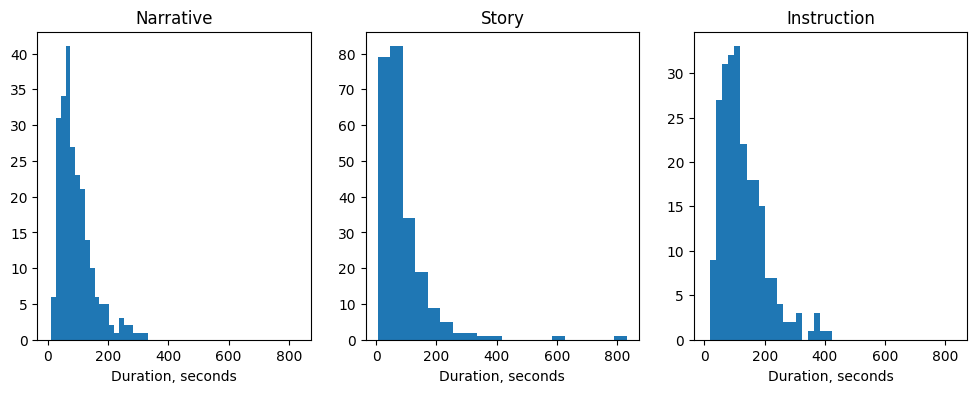

In [ ]:
import mutagen
from mutagen.wave import WAVE

def recording_lengths_plot(files, ax, title=None, data_folder=os.path.join(DRIVE_PATH, 'wav files')):
    lengths = []
    audio_length = {}

    for _, filename in files.items():
        if filename is not None:
            audio = WAVE(os.path.join(data_folder, filename))
            lengths.append(int(audio.info.length))
            audio_length[filename] = int(audio.info.length)
        
    ax.hist(lengths, bins=20)
    if title:
        ax.set_title(title)
    ax.set_xlabel('Duration, seconds')
    return audio_length


fig, ax = plt.subplots(1, 3, sharex=True, figsize=(12, 4))    
narr_length = recording_lengths_plot(df['audio.narrative'], ax[0], title='Narrative')
story_length = recording_lengths_plot(df['audio.story'], ax[1], title='Story')
instr_length = recording_lengths_plot(df['audio.instruction'], ax[2], title='Instruction')
plt.show()

In [ ]:
min_narr = min(narr_length, key=narr_length.get)
max_narr = max(narr_length, key=narr_length.get)

min_story = min(story_length, key=story_length.get)
max_story = max(story_length, key=story_length.get)

min_instr = min(instr_length, key=instr_length.get)
max_instr = max(instr_length, key=instr_length.get)

print(f'Narrative:\n\t  Shortest audio: {min_narr}\t Length: {narr_length[min_narr]}\n\t  Longest Audio: {max_narr}\t Length: {narr_length[max_narr]} \n\n' )
print(f'Story:\n\t  Shortest audio: {min_story}\t Length: {story_length[min_story]}\n\t  Longest Audio: {max_story} \t Length: {story_length[max_story]} \n\n' )
print(f'Instruction:\n\t  Shortest audio: {min_instr}\t Length: {instr_length[min_instr]}\n\t  Longest Audio: {max_instr}\t Length: {instr_length[max_instr]}\n' )

Narrative:
	  Shortest audio: PN-002-pic-1-adventure.wav	 Length: 10
	  Longest Audio: PN-036-pic-1-sportsman.wav	 Length: 332 


Story:
	  Shortest audio: PD-096-pers-1-present.wav	 Length: 6
	  Longest Audio: PN-312-pers-1-trip.wav 	 Length: 832 


Instruction:
	  Shortest audio: PD-046-instr-1-chair.wav	 Length: 18
	  Longest Audio: PN-260-instr-1-bench.wav	 Length: 425



In [ ]:
np.quantile(list(narr_length.values()), [0.85])

array([141.75])

In [ ]:
pd.DataFrame(data=list(narr_length.values())).describe()

0
count  236.000000
mean    93.411017
std     58.433346
min     10.000000
25%     52.000000
50%     77.500000
75%    119.000000
max    332.000000

In [ ]:
df_lengths = pd.DataFrame(data=[list(narr_length.values()) + list(story_length.values()) + list(instr_length.values())]).T

df_lengths.describe()

0
count  708.000000
mean   102.480226
std     76.348404
min      6.000000
25%     52.750000
50%     83.000000
75%    131.000000
max    832.000000

In [ ]:
df_lengths.describe().T[['min', '25%', '50%', '75%', 'max']].rename({0: 'duration'}, axis=0)

min    25%   50%    75%    max
duration  6.0  52.75  83.0  131.0  832.0

In [ ]:
df_lengths

0
0    144
1     51
2     61
3     26
4     35
..   ...
703  236
704  271
705   86
706   78
707  119

[708 rows x 1 columns]

In [ ]:
df_lengths.to_csv('recording_lengths_all.csv')

In [ ]:
narr_length.to_csv('recording_lengths_narrative.csv')
story_length.to_csv('recording_lengths_story.csv')
instr_length.to_csv('recording_lengths_instr.csv')

AttributeError: ignored

In [ ]:
concatenated_df = pd.DataFrame([[i[:6] for i in narr_length.keys()] ,narr_length.values(), story_length.values(), instr_length.values()]).T

concatenated_df.rename({0 : 'id', 1 : 'narrative', 2 : 'story', 3 : 'instruction'}, axis = 1, inplace=True)

In [ ]:
concatenated_df.to_csv('recording_lengths_by_type.csv')

## **Test audio transformations**

In [ ]:
signal, sr = lb.load(os.path.join(DRIVE_PATH, 'wav files/PN-019-pic-1-sportsman.wav'), sr=SR)

In [ ]:
import IPython.display as ipd

ipd.Audio(signal, rate=sr)

In [ ]:
signal_trimmed, index = lb.effects.trim(signal, top_db=40)

In [ ]:
signal.shape

(420398,)

In [ ]:
signal_trimmed.shape

(413184,)

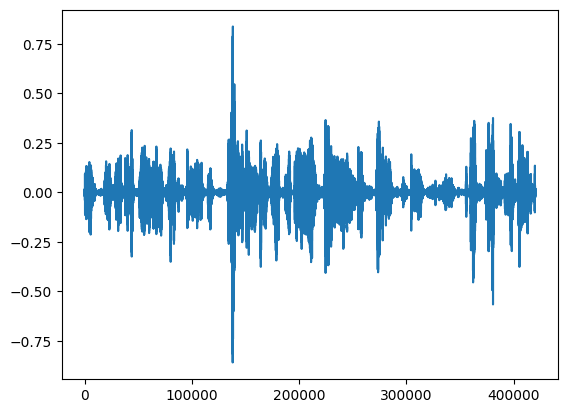

In [ ]:
plt.plot(signal)

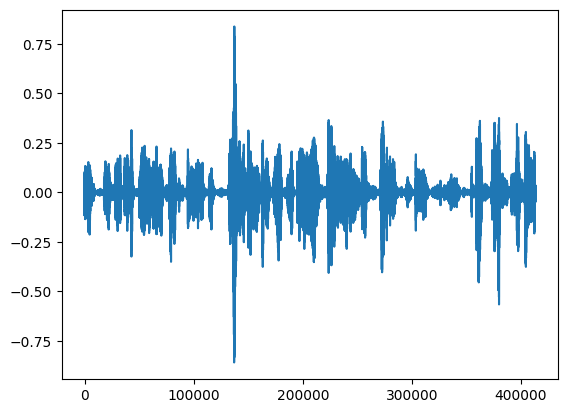

In [ ]:
plt.plot(signal_trimmed)

In [ ]:
# print(lb.get_duration(signal_trimmed))
print(lb.get_duration(signal))

TypeError: ignored

In [ ]:
ipd.Audio(signal_trimmed, rate=sr)

In [ ]:
signal

array([-1.7172958e-06,  5.3723070e-06, -5.4872498e-07, ...,
       -1.6015458e-03, -2.5106084e-03, -3.6156469e-03], dtype=float32)

In [ ]:
y, sr = lb.load(lb.ex('choice'))

In [ ]:
y.shape

(551823,)

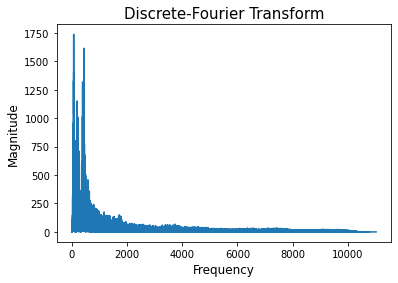

In [ ]:
fast_fourier_transf = np.fft.fft(signal)

magnitude = np.abs(fast_fourier_transf)

frequency = np.linspace(0, sr, len(magnitude))

left_mag = magnitude[:int(len(magnitude)/2)]
left_freq = frequency[:int(len(frequency)/2)]


plt.plot(left_freq, left_mag)
plt.title('Discrete-Fourier Transform', fontdict=dict(size=15))
plt.xlabel('Frequency', fontdict=dict(size=12))
plt.ylabel('Magnitude', fontdict=dict(size=12))
plt.show()

In [ ]:
len(fast_fourier_transf)

2119465

In [ ]:
dur_time = lb.get_duration(signal,sr=sr)
time_sec = round(dur_time)
S = lb.feature.melspectrogram(y=signal, sr=sr, fmax=8000)
S_dB = lb.power_to_db(S, ref=np.max)

In [ ]:
start = 0
end = time_sec
time_series_sec = np.linspace(start,end,len(S_dB[0]))

In [ ]:
S_dB

array([[-80.      , -80.      , -80.      , ..., -60.743454, -64.30786 ,
        -66.23009 ],
       [-80.      , -80.      , -80.      , ..., -52.145798, -56.14982 ,
        -63.66688 ],
       [-80.      , -80.      , -80.      , ..., -47.60678 , -52.440735,
        -59.49299 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [ ]:
len(S_dB[0])

4140

In [ ]:
sp_c = lb.feature.spectral_centroid(y = signal, sr = sr, hop_length = 256)

sp_dB = lb.power_to_db(sp_c, ref=np.max)

In [ ]:
pd.DataFrame(sp_dB[0])

0
0    -0.020700
1    -0.019299
2    -0.008215
3    -0.001715
4    -0.003795
...        ...
8275 -9.189865
8276 -8.829039
8277 -8.164951
8278 -7.492827
8279 -7.198062

[8280 rows x 1 columns]

In [ ]:
len(sp_dB[0])

8280

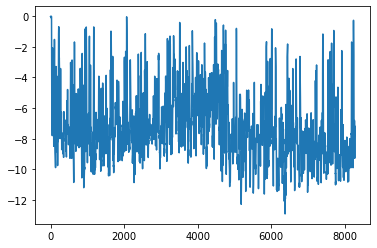

In [ ]:
plt.plot(sp_dB[0])
plt.show()

Text(0.5, 1.0, 'LP Model Forward Prediction')

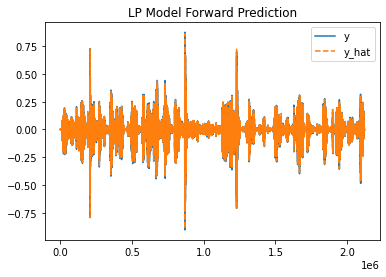

In [ ]:
import scipy

a = lb.lpc(signal, order=3)
b = np.hstack([[0], -1 * a[1:]])
y_hat = scipy.signal.lfilter(b, [1], signal)
fig, ax = plt.subplots()
ax.plot(signal)
ax.plot(y_hat, linestyle='--')
ax.legend(['y', 'y_hat'])
ax.set_title('LP Model Forward Prediction')

In [ ]:
len(y_hat)

2119465

In [ ]:
b

array([ 0.        ,  1.2611624 , -0.35398376,  0.05945677])

In [ ]:
# training = TimeSeriesDataSet(
#     df[lambda x: x.time_idx],
#     time_idx="time_idx",
#     target="value",
#     group_ids=["series"],
#     static_categoricals=[
#         "series"
#     ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
#     time_varying_unknown_reals=["value"]
# )

# validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
# batch_size = 128

# train_dataloader = training.to_dataloader(
#     train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
# )
# val_dataloader = validation.to_dataloader(
#     train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
# )